## Create map of NES-LTER transect underway data with CTD locations

Draw a map of the NES-LTER region showing a continuous underway variable value (e.g., sea surface temperature, salinity, etc.) and include markers for CTD cast locations.

#### Dependencies

* [`nes-lter-ims`](https://github.com/WHOIGit/nes-lter-ims)
* cartopy
* matplotlib

#### Data

* Underway data CSVs (e.g., `Data60Sec_Daily_20180131-000000.csv`)
* CTD cast header files (e.g., `EN608_D4_Cast07.hdr`)

### Acknowledgements

This notebook is based on [one by Phillipe Fernandez](http://nbviewer.jupyter.org/gist/ocefpaf/d0dfb835be68eaf977d08cefdd97dd81), thanks to Rich Signell for pointing me to it

### Parse underway data

In [1]:
import os

cruise='en617'

DIR = r'D:\nes-lter-ims-test-data\{}_underway'.format(cruise)
assert os.path.exists(DIR)

In [2]:
from neslter.parsing.underway import compile_underway

# compile all underway 60s data into a single dataframe
uw = compile_underway(DIR)

# the dataframe has over 100 columns, we need latitude, longitude, and an underway variable to plot

In [3]:
# lat/lon comes from columns with names like "gps_{mfg/model}_latitude"

gps2use = 'garmin741' # mfg/model
LAT_COL = 'gps_{}_latitude'.format(gps2use)
LON_COL = 'gps_{}_longitude'.format(gps2use)

### Prepare variable for plotting

In [4]:
var2plot = 'tsg1_sst' # the variable we're going to plot
var2plot_name = 'Sea Surface Temperature (°C)' # a description of it

Smooth values with a rolling mean. This is necessary because of large transients in the data that do not reflect real conditions.

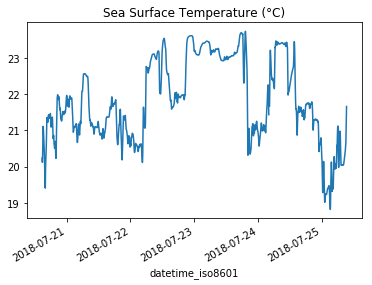

In [5]:
%matplotlib inline

window_size = 15 # in minutes

smoothed_values = uw[var2plot].rolling(window_size).mean()
smoothed_values.plot(title=var2plot_name);

### Get CTD cast locations

In [6]:
from neslter.parsing.ctd.hdr import compile_hdr_files

HDR_DIR = r'D:\nes-lter-ims-test-data\{}_ctd_proc'.format(cruise)
assert os.path.exists(HDR_DIR)

cast_md = compile_hdr_files(HDR_DIR)
cast_md.head()

,cruise,cast,date,latitude,longitude
0,EN617,1,2018-07-20 17:23:53,41.200667,-70.885333
1,EN617,2,2018-07-20 22:57:14,41.030333,-70.880667
2,EN617,3,2018-07-21 01:15:21,41.030000,-70.769833
3,EN617,4,2018-07-21 02:58:24,41.030333,-70.991167
4,EN617,5,2018-07-21 06:39:49,40.863667,-70.883000


### Draw the map

The map is a matplotlib scatterplot with a basemap image made from ESRI's [World_Ocean_Base](https://doc.arcgis.com/en/data-appliance/6.4/maps/world-ocean-base.htm) tile service. `cartopy` is used to render the tiles.

In [7]:
import cartopy.crs as ccrs

# use the PlateCarree projection
projection = ccrs.PlateCarree()

In [8]:
import matplotlib.pyplot as plt

def make_map(projection=projection, figsize=(8, 8)):
    fig, ax = plt.subplots(
        figsize=figsize,
        subplot_kw={'projection': projection},
    )
    return fig, ax

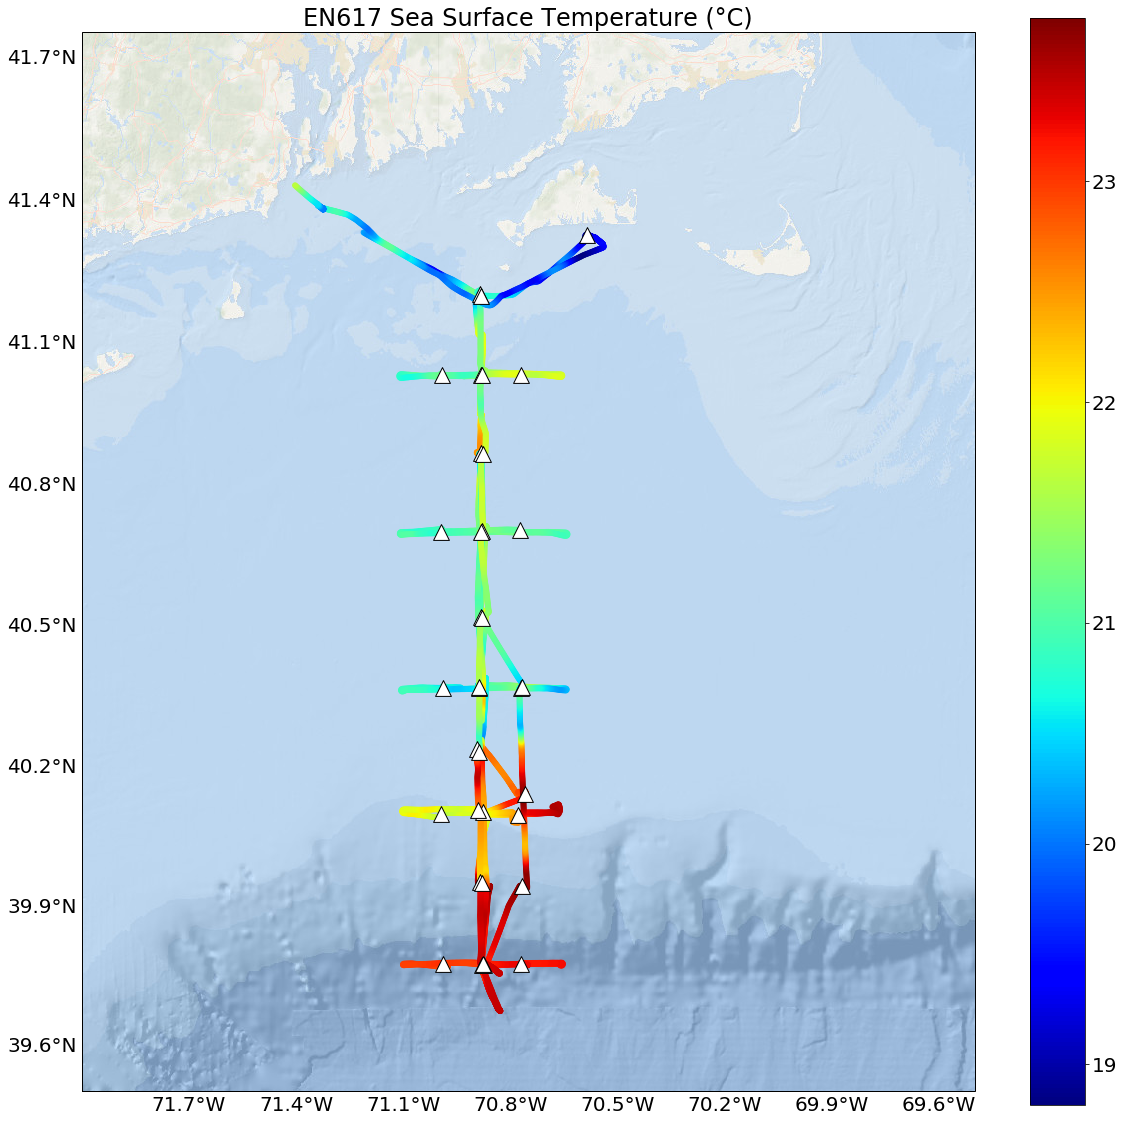

In [9]:
from cartopy.io.img_tiles import GoogleTiles
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib

# increase global font size
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

# use the ESRI "World_Ocean_Base" map tile service
tile_url_template = 'https://server.arcgisonline.com/arcgis/rest/services/Ocean/World_Ocean_Base/MapServer/tile/{z}/{y}/{x}'
tiles = GoogleTiles(url=tile_url_template)

# build the map
fig, ax = make_map(projection=tiles.crs, figsize=(20, 20))

# set map extent
# this box roughly captures the LTER area
w, e, s, n = -72, -69.5, 39.5, 41.75
ax.set_extent([w, e, s, n])

# add the tile image at a specific zoom level
zoom = 9 # set to lower values for less detail (faster rendering)
ax.add_image(tiles, zoom)

# plot the underway variable
uw_scatter = plt.scatter(uw[LON_COL], uw[LAT_COL], marker='.', s=100,
            c=smoothed_values, cmap='jet',
           transform=projection)
plt.colorbar(uw_scatter)

# plot the CTD cast locations
plt.scatter(cast_md.longitude, cast_md.latitude, marker='^', s=250,
            c='white', edgecolors='black',
            transform=projection)

# title the plot after the cruise and variable description
plt.title('{} {}'.format(cruise.upper(), var2plot_name))

# configure tick labels
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = gl.ylabels_right  = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlines = gl.ylines = False